## first parcels test

* first test with real data 

In [10]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy as crs
cwd =os.getcwd()

In [16]:
#load velocity data
path = cwd +'/data/'
data = 'MetO-NWS-PHY-dm-CUR_1658776649348.nc'
ds = nc.Dataset(path + data)

lon_grid =  ds['lon'][:]
lat_grid =  ds['lat'][:]
print(ds)
print(lat_grid)

(1240,)


In [12]:
#readingmutiple  netcdf velocity files  
filenames = path + data
#ilenames = {'U' :"MovingEddies_data/moving_eddiesU.nc",
#             'V' :"MovingEddies_data/moving_eddiesV.nc"}
variables = {'U': 'uo',
             'V': 'vo'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'
              }

fieldset = FieldSet.from_netcdf(filenames,variables,dimensions)

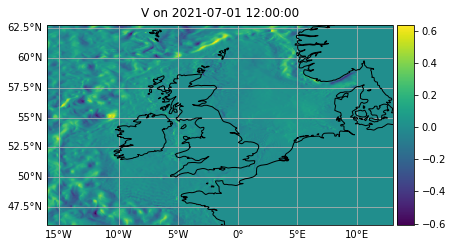

In [13]:
fieldset.V.show()

* construnct function to generate particles at each station from the station.csv data (1°x1°)

In [5]:
stations = pd.read_csv("data/stations.csv")
stations
#for ind, row in stations.iterrows():   
#    lats_e, lons_e = genStationParticles(row['lat'],row['lon'], Num = 100)

,station,country,lat,lon
0,Walton_Backwaters,UK_eastcoast,51.862920,1.290133
1,Poole_harbor,UK_channel,50.683427,-1.943239
2,Sylt,Germany,55.029428,8.433999
3,Bourgneuf_Bay,\tFrance,46.986492,-2.040351


In [6]:
dom = {'N':60, 'S':46, 'E':12.5, 'W':-4}#

def make_landmask(data):
    """Returns landmask where land = 1 and ocean = 0
    fielddata is a netcdf fle.
    """
    datafile = Dataset(data)

    landmask = datafile.variables['uo'][0, 0]
    landmask = np.ma.masked_invalid(landmask)
    landmask = landmask.mask.astype('int')

    return landmask



def genStationParticle(index, num = 1000, size = 1):

    '''
    generates [num] number of random coordinates 
    in a box centered around [lat,lon] of a station from station.csv with a side length of [size]
    '''
    print(f'Station: {stations.loc[index,"station"]}')
    lat = stations.loc[index,'lat']
    lon = stations.loc[index,'lon']
    
    
    lon_bound = (lon - size/2, lon + size/2)
    lat_bound = (lat - size/2, lat + size/2)
    lons = np.random.uniform(low=lon_bound[0], high = lon_bound[1], size=num)
    lats = np.random.uniform(low=lat_bound[0], high = lat_bound[1], size=num)
        
    #maybe check for land in possible particle start location?
    
    pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=lons, # a vector of release longitudes 
                             lat=lats)    # a vector of release latitudes

    pset.show(field=fieldset.U,domain = dom)    
    return pset

Station: Sylt


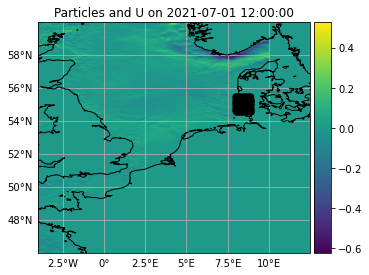

In [7]:
np.random.seed(0)
pset_sylt = genStationParticle(index = 2)

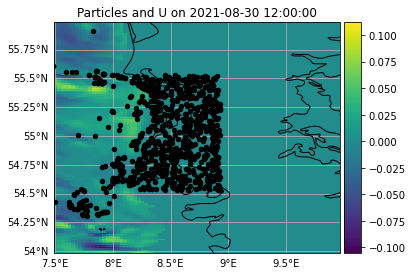

In [14]:
pset_sylt.show(field=fieldset.U,domain =  {'N':56, 'S':54, 'E':10, 'W':7.5})  

INFO: Temporary output files are stored in out-IBPAZEJD.
INFO: You can use "parcels_convert_npydir_to_netcdf out-IBPAZEJD" to convert these to a NetCDF file during the run.
100%|████████████████████████| 2592000.0/2592000.0 [00:02<00:00, 1007468.04it/s]
/home/tknoop/anaconda3/envs/py_parcels/lib/python3.10/site-packages/parcels/plotting.py:192: RuntimeWarning: invalid value encountered in divide
  u = np.where(speed > 0., data[0]/speed, 0)
/home/tknoop/anaconda3/envs/py_parcels/lib/python3.10/site-packages/parcels/plotting.py:193: RuntimeWarning: invalid value encountered in divide
  v = np.where(speed > 0., data[1]/speed, 0)


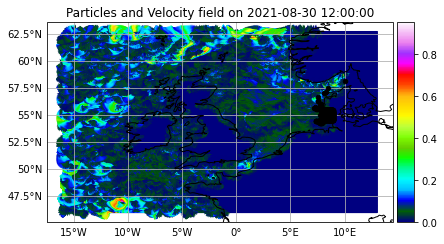

In [9]:
output_file = pset_sylt.ParticleFile(name="sylt_particles.nc", outputdt=timedelta(hours=1)) # the file name and the time step of the outputs
pset_sylt.execute(AdvectionRK4,                 # the kernel (which defines how particles move)
             runtime=timedelta(days=30),    # the total length of the run
             dt=timedelta(minutes=10),      # the timestep of the kernel
             output_file=output_file)
pset_sylt.show(field='vector')